In [93]:
import pandas as pd
import numpy as np
import pickle

from helpers import load_photos, cv_scores

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

In [94]:
from PIL import Image
import cv2
from mtcnn import MTCNN
import tensorflow
from fer import FER

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, ensemble, linear_model, neighbors, naive_bayes
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve 
from sklearn.metrics import confusion_matrix, precision_recall_curve,f1_score, fbeta_score, log_loss
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import svm, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [96]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Load the data

### Image data

In [97]:
images = load_photos('selfie_data/images', 128)

## Non-Pixel Features

In [116]:
file = 'selfie_data/selfie_dataset.txt'
features = pd.read_csv(file, sep=' ', header=None)

In [99]:
col_names_str = '''img_file popularity_score partial_faces is_female baby child teenager youth middle_age senior 
                    white black asian oval_face round_face heart_face smiling mouth_open frowning 
                    wearing_glasses wearing_sunglasses wearing_lipstick tongue_out duck_face 
                    black_hair blond_hair brown_hair red_hair curly_hair straight_hair braid_hair 
                    showing_cellphone using_earphone using_mirror braces wearing_hat harsh_lighting dim_lighting'''

col_names = col_names_str.split()

features.columns = col_names

features.img_file = np.array(features.img_file) +'.jpg'

In [100]:
features['is_popular'] = np.where(features.popularity_score < 4.5, 0, 1)

In [101]:
features.replace(-1, int(0), inplace=True)

In [102]:
features.groupby('is_popular').mean()

,popularity_score,partial_faces,is_female,baby,teenager,youth,middle_age,senior,white,black,asian,oval_face,round_face,heart_face,smiling,mouth_open,frowning,wearing_glasses,wearing_sunglasses,wearing_lipstick,tongue_out,duck_face,black_hair,blond_hair,brown_hair,red_hair,curly_hair,straight_hair,braid_hair,showing_cellphone,using_earphone,using_mirror,braces,wearing_hat,harsh_lighting,dim_lighting
is_popular,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.979835,0.227931,0.683829,0.005329,0.136347,0.660162,0.025248,0.000331,0.550092,0.054429,0.059831,0.558986,0.133995,0.113451,0.242631,0.039471,0.010658,0.081514,0.058986,0.129070,0.017861,0.056928,0.190665,0.078795,0.321132,0.019294,0.181955,0.304851,0.008600,0.120470,0.026461,0.121316,0.008931,0.050827,0.060639,0.060639
1,4.920158,0.188016,0.766738,0.002599,0.130745,0.697085,0.022012,0.000357,0.563334,0.042800,0.076582,0.588403,0.131764,0.120351,0.285591,0.037960,0.008051,0.087435,0.074085,0.165699,0.017681,0.052634,0.183787,0.096250,0.341231,0.024916,0.213747,0.352644,0.010394,0.110924,0.028534,0.111128,0.012382,0.047488,0.047539,0.047539


In [103]:
features.shape

(46836, 39)

## Merge the photos df with the non-photo features df

In [104]:
df_all = images.merge(features, left_on='img_file', right_on='img_file')

## Generate Emotion Features

In [115]:
detector = FER()

In [106]:
angry = lambda x: detector.detect_emotions(x)[0]['emotions']['angry'] if detector.detect_emotions(x) else np.nan
happy = lambda x: detector.detect_emotions(x)[0]['emotions']['happy'] if detector.detect_emotions(x) else np.nan
sad = lambda x: detector.detect_emotions(x)[0]['emotions']['sad'] if detector.detect_emotions(x) else np.nan
surprise = lambda x: detector.detect_emotions(x)[0]['emotions']['surprise'] if detector.detect_emotions(x) else np.nan
neutral = lambda x: detector.detect_emotions(x)[0]['emotions']['neutral'] if detector.detect_emotions(x) else np.nan

In [107]:
df_all['angry'] = df_all.images.apply(angry)
df_all['happy'] = df_all.images.apply(happy)
df_all['sad'] = df_all.images.apply(sad)
df_all['surprise'] = df_all.images.apply(surprise)
df_all['neutral'] = df_all.images.apply(neutral)

### Drop all photos for which emotion cannot be captured

In [108]:
df_all.dropna(inplace=True)

In [109]:
df_all.to_pickle('pickles/images_features_emotions_target.pkl')

In [110]:
classifer_features = ['is_female', 'youth', 'smiling', 'angry', 
                          'happy', 'sad', 'surprise', 'neutral', 'is_popular']

df = df_all[classifer_features]

In [111]:
df.to_pickle('pickles/classifier_features.pkl')

In [113]:
df.is_popular.value_counts()

0    9390
1    8932
Name: is_popular, dtype: int64

In [6]:
df_all = pd.read_pickle('pickles/images_features_emotions_target.pkl')
df = pd.read_pickle('pickles/classifier_features.pkl')

## Claffification models

In [7]:
X, y = df.drop('is_popular', axis=1), df.is_popular

In [8]:
# pipelines in order to scale data
log_pipe = make_pipeline(StandardScaler(), LogisticRegression(solver= 'liblinear'))
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))

# models that do not require scalling
nbB = BernoulliNB()
nbG = GaussianNB()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

models = {'Logistic':log_pipe, 'KNN': knn_pipe,  'NB Bernoulli': nbB, 'NB Gauss ':nbG, 
          'Random Forest':rfc, 'Gradient Boosting': gbc}

scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [40]:
cv_scores(X, y, models, scores, 10)

Logistic
accuracy 0.5594043785491813
precision 0.5407225640225912
recall 0.6277165638570079
f1 0.5808957408435149
roc_auc 0.5813185766992758


KNN
accuracy 0.5243114053941272
precision 0.5117899929542862
recall 0.48871309204030283
f1 0.49982904049533106
roc_auc 0.5312160645592487


NB Bernoulli
accuracy 0.54632066625943
precision 0.5485019999355898
recall 0.3827924235828724
f1 0.45083220057355905
roc_auc 0.5725973962229973


NB Gauss 
accuracy 0.5506813674105022
precision 0.5372378028669459
recall 0.5529125038487264
f1 0.5448008022017918
roc_auc 0.5736698987186104


Random Forest
accuracy 0.5369959502567854
precision 0.525007686269747
recall 0.5020086636159979
f1 0.517253925923525
roc_auc 0.5406003040277441


Gradient Boosting
accuracy 0.5597051555669516
precision 0.5445389636284238
recall 0.5823782475288521
f1 0.562630127987573
roc_auc 0.5792100788147625




### Feature importance

In [9]:
X, X_test, y, y_test = train_test_split(X, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

#### From logistic

In [10]:
log = LogisticRegression()
log.fit(X, y)

log_importances = log.coef_[0]
log_feature_importance = sorted(list(zip(log_importances, X.columns)), reverse=True)
log_feature_importance

[(0.46418711648079525, 'is_female'),
 (0.29787508478375047, 'surprise'),
 (0.18421380326588221, 'happy'),
 (0.08946342053828218, 'youth'),
 (0.001979732833450853, 'smiling'),
 (-0.015128401220833528, 'neutral'),
 (-0.033527820828105404, 'sad'),
 (-0.6960775163108052, 'angry')]

In [63]:
max(log_feature_importance)[0]

0.46418711648079525

In [68]:
coef_impact =[abs(impact) for impact in map(lambda item: item[0]/max(log_feature_importance)[0], 
                                            log_feature_importance[:5])]

In [69]:
coef_impact

[1.0,
 0.6417133828316288,
 0.396852469026903,
 0.19273137353863534,
 0.0042649456720386175]

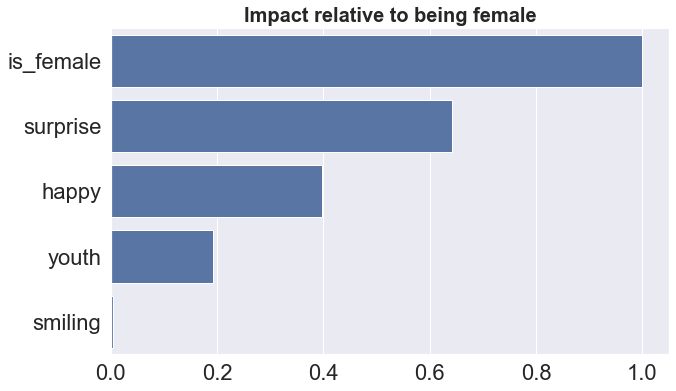

In [75]:
plt.figure(figsize=(10,6))
sns.barplot(x=coef_impact, y=[item[1] for item in log_feature_importance[:5]], orient='h', color='b')
plt.title('Impact relative to being female',weight='bold', size=20);

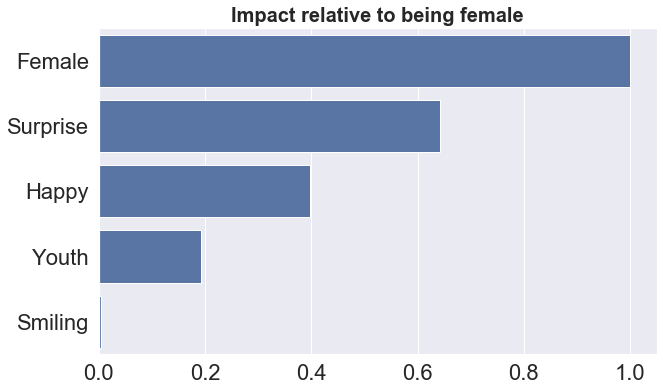

In [76]:
plt.figure(figsize=(10,6))
sns.barplot(x=coef_impact, y= ['Female', 'Surprise', 'Happy', 'Youth', 'Smiling'], orient='h', color='b')
plt.title('Impact relative to being female',weight='bold', size=20);

#### From gradient boost

In [80]:
gbc = GradientBoostingClassifier()
gbc.fit(X, y)

gb_importances = list(gbc.feature_importances_)
gb_feature_importance = sorted(list(zip(gb_importances, X.columns)), reverse=True)
gb_feature_importance

[(0.3360191092008619, 'is_female'),
 (0.22045890952655744, 'angry'),
 (0.11020811510175016, 'happy'),
 (0.10721569531110178, 'neutral'),
 (0.10346088732929559, 'sad'),
 (0.09114810401414015, 'surprise'),
 (0.023262418805818384, 'youth'),
 (0.008226760710474483, 'smiling')]

In [81]:
coef_impact =[abs(impact) for impact in map(lambda item: item[0]/max(gb_feature_importance)[0], 
                                            gb_feature_importance[:5])]

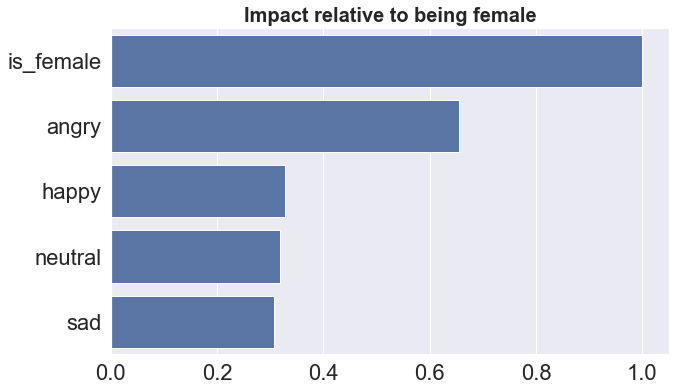

In [82]:
plt.figure(figsize=(10,6))
sns.barplot(x=coef_impact, y=[item[1] for item in gb_feature_importance[:5]], orient='h', color='b')
plt.title('Impact relative to being female',weight='bold', size=20);

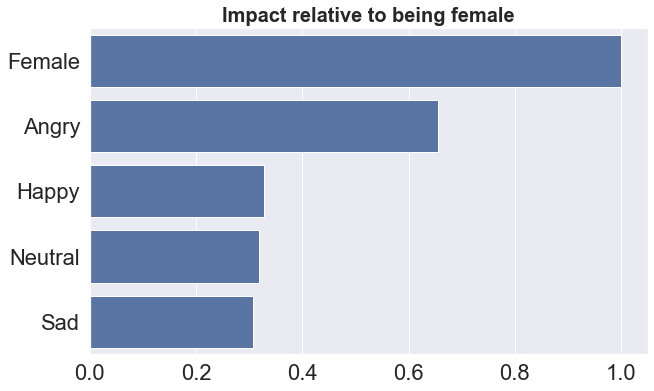

In [83]:
plt.figure(figsize=(10,6))
sns.barplot(x=coef_impact, y=['Female', 'Angry', 'Happy', 'Neutral', 'Sad'], orient='h', color='b')
plt.title('Impact relative to being female',weight='bold', size=20);

## Feature engineering

In [24]:
df_fe = df.copy()

In [25]:

# bundling the emotions together
df_fe['pos_emo'] = df_fe['happy'] + df_fe['surprise']
df_fe['neg_emo'] = df_fe['sad'] + df_fe['angry']

# see if young females are more popular (since females in general seem to be more popular)
df_fe['young_f'] = df_fe['is_female'] + df_fe['youth']

# making this field either young_f or not young_f
df_fe['young_f'] = np.where(df_fe['young_f'] == 2, 1, 0)

09-06-2020:16:45:18,998 INFO     [utils.py:141] NumExpr defaulting to 8 threads.


In [14]:
best_models = {'Logistic':log_pipe, 'Gradient Boosting': gbc}

In [15]:
X, y = df_fe.drop('is_popular', axis=1), df_fe.is_popular

X, X_test, y, y_test = train_test_split(X, y, random_state=0)

In [16]:
cv_scores(X, y, best_models, scores, 10)

Logistic
accuracy 0.5569824586784977
precision 0.540221607284711
recall 0.6110297461337543
f1 0.5734042209464294
roc_auc 0.5795758907118107


Gradient Boosting
accuracy 0.5588532680333931
precision 0.5450473648729067
recall 0.5742715673562959
f1 0.5591889658911883
roc_auc 0.578133504652264




## PCA (on pixel data)

In [17]:
X_pixels, y = df_all.images, df_all.is_popular
X_pixels = np.array([x.flatten() for x in X_pixels])
X_centered = X_pixels - X_pixels.mean()

In [18]:
X_centered = X_centered/255

In [19]:
X_centered[0]

array([ 0.01316447,  0.00532134,  0.10728212, ..., -0.37507082,
       -0.46134533, -0.32016886])

In [20]:
X_centered.shape

(19948, 67500)

In [21]:
pca = PCA(n_components=300)
pca.fit(X_centered)
pcafeatures = pca.transform(X_centered)

In [28]:
pd.DataFrame(pcafeatures).to_pickle('pickles/pca_features.pkl')

In [13]:
pcafeatures = pd.read_pickle('pickles/pca_features.pkl')

In [21]:
pcafeatures = pcafeatures.values

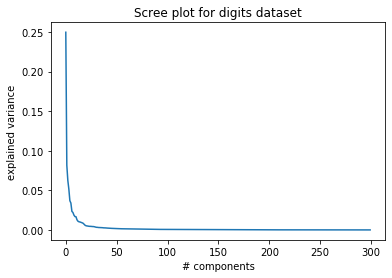

In [30]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for digits dataset');

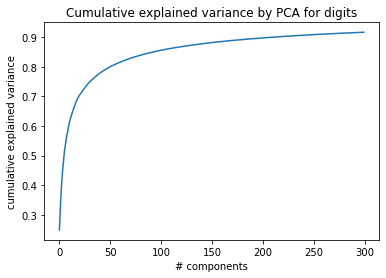

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');

In [22]:
reduced_pca_features = pcafeatures[:, :30]

## Classification on PCA features

In [27]:
X, y = reduced_pca_features, df_fe.is_popular

In [28]:
X.shape

(19948, 30)

In [29]:
X, X_test, y, y_test = train_test_split(X, y, random_state=0)

In [41]:
cv_scores(X, y, models, scores, 10)

Logistic
accuracy 0.6141976912827437
precision 0.6186710866866292
recall 0.5442339853806114
f1 0.5789526282561246
roc_auc 0.6570946886207143


KNN
accuracy 0.6089832963609929
precision 0.6052800803272004
recall 0.5675468365371967
f1 0.5856585721671503
roc_auc 0.6517587989780546


NB Bernoulli
accuracy 0.5911379800599416
precision 0.5872833401403442
recall 0.542586579476483
f1 0.5639625824533196
roc_auc 0.6268945807697538


NB Gauss 
accuracy 0.6242898899403084
precision 0.6333279661866907
recall 0.5447808031268202
f1 0.5855794582149991
roc_auc 0.6781933209969395


Random Forest
accuracy 0.6437422081239127
precision 0.6496908177528496
recall 0.5816754044760133
f1 0.6121633133157603
roc_auc 0.7061062301091452


Gradient Boosting
accuracy 0.6387936746934154
precision 0.6533971412394288
recall 0.5517729297029146
f1 0.597994497619182
roc_auc 0.7025124545417952




In [30]:
df_fe.reset_index(inplace=True)

In [31]:
all_features = pd.concat([df_fe, pd.DataFrame(reduced_pca_features)], axis=1)

In [37]:
all_features.drop('index', axis=1, inplace=True)

In [39]:
X, y = all_features.drop('is_popular', axis=1), all_features.is_popular

In [41]:
adc = AdaBoostClassifier()

best_models = {'Random Forest' :rfc, 'Gradient Boosting': gbc, 'AdaBoost': adc}

In [114]:
cv_scores(X, y, best_models, scores, 10)

Random Forest
accuracy 0.6409160815780675
precision 0.6554969653347462
recall 0.5709435484727191
f1 0.6117941681400939
roc_auc 0.7078859140085361


Gradient Boosting
accuracy 0.6431218467432374
precision 0.6507418309834561
recall 0.5751683353329016
f1 0.6105776663389262
roc_auc 0.7090350592523417


AdaBoost
accuracy 0.6263786849269615
precision 0.6273687620786262
recall 0.5719712911548303
f1 0.5983460594228868
roc_auc 0.6791375120938299




In [42]:
X, X_test, y, y_test = train_test_split(X, y, random_state=0)

In [43]:
gbc = GradientBoostingClassifier()
gbc.fit(X, y)

gb_importances = list(gbc.feature_importances_)
gb_feature_importance = sorted(list(zip(gb_importances, X.columns)), reverse=True)
gb_feature_importance

[(0.2817377787049635, 0),
 (0.07759376085431548, 2),
 (0.07649702603806958, 10),
 (0.07518168110743731, 4),
 (0.054915024259899366, 11),
 (0.049115078464164554, 1),
 (0.0436950524859917, 'is_female'),
 (0.03447766212831023, 5),
 (0.02447848199085868, 7),
 (0.022814970018927, 23),
 (0.02252216958882998, 16),
 (0.0196377676900307, 9),
 (0.019187250122796658, 18),
 (0.018364172977144228, 24),
 (0.016860345744786683, 29),
 (0.016023749474134978, 'angry'),
 (0.014603289002640116, 19),
 (0.012392503534443478, 21),
 (0.011443694683187466, 15),
 (0.01118533715897626, 14),
 (0.0109404082583967, 17),
 (0.010699342868339023, 3),
 (0.008944098869751753, 8),
 (0.007470298836545542, 'sad'),
 (0.007073205178795586, 22),
 (0.006900780609607299, 13),
 (0.006811314515068546, 27),
 (0.006153959944983577, 26),
 (0.005999711585998249, 25),
 (0.005956930299812262, 'pos_emo'),
 (0.005896771110978023, 28),
 (0.003933954274991787, 20),
 (0.0031271249428811983, 'young_f'),
 (0.0024183827116243963, 6),
 (0.00160

In [46]:
rfc = RandomForestClassifier()
rfc.fit(X, y)

rf_importances = list(rfc.feature_importances_)
rf_feature_importance = sorted(list(zip(rf_importances, X.columns)), reverse=True)
rf_feature_importance

[(0.0661154177974323, 0),
 (0.034930391752635744, 2),
 (0.03435700190942199, 4),
 (0.033489869878238356, 10),
 (0.032641957186445164, 11),
 (0.0310064861982807, 1),
 (0.03084723730361405, 5),
 (0.02891537718726354, 7),
 (0.028824950216706866, 24),
 (0.028629140597479768, 9),
 (0.028141610559504784, 19),
 (0.02782120743390068, 18),
 (0.027533325701747748, 29),
 (0.027187803364685077, 16),
 (0.027098240474227858, 15),
 (0.02709031746602333, 23),
 (0.026654978963034783, 14),
 (0.026412504529923626, 21),
 (0.026314839086430845, 25),
 (0.026011799108638253, 27),
 (0.025804233996505593, 8),
 (0.02566653017707172, 3),
 (0.025489502776066146, 13),
 (0.025456623371475178, 26),
 (0.025217098228247654, 12),
 (0.025006750064398245, 28),
 (0.024828703955849143, 20),
 (0.024731245830442845, 22),
 (0.024621887158719304, 17),
 (0.024454154935043562, 6),
 (0.018752479249272227, 'neutral'),
 (0.01791937421945832, 'pos_emo'),
 (0.016999792129751657, 'happy'),
 (0.01639368733177965, 'neg_emo'),
 (0.015747

In [48]:
adc = AdaBoostClassifier()
adc.fit(X, y)

ab_importances = list(adc.feature_importances_)


In [53]:
list(zip(ab_importances, X.columns))

[(0.04, 'is_female'),
 (0.0, 'youth'),
 (0.0, 'smiling'),
 (0.02, 'angry'),
 (0.0, 'happy'),
 (0.02, 'sad'),
 (0.0, 'surprise'),
 (0.0, 'neutral'),
 (0.02, 'pos_emo'),
 (0.0, 'neg_emo'),
 (0.0, 'young_f'),
 (0.1, 0),
 (0.04, 1),
 (0.06, 2),
 (0.02, 3),
 (0.1, 4),
 (0.02, 5),
 (0.0, 6),
 (0.02, 7),
 (0.0, 8),
 (0.02, 9),
 (0.08, 10),
 (0.04, 11),
 (0.0, 12),
 (0.02, 13),
 (0.04, 14),
 (0.02, 15),
 (0.02, 16),
 (0.04, 17),
 (0.02, 18),
 (0.04, 19),
 (0.0, 20),
 (0.04, 21),
 (0.02, 22),
 (0.02, 23),
 (0.02, 24),
 (0.0, 25),
 (0.02, 26),
 (0.02, 27),
 (0.0, 28),
 (0.06, 29)]